# Определение возраста покупателей

__Описание задачи:__

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

Последовательность выполнения проекта:
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить и проанализировать нейронную сеть и рассчитать её качество.

__Описание данных:__

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). Они находятся в папке /datasets/faces/.

Все изображения находятся в одной папке: `/final_files`. В той же папке находится csv-файл `labels.csv` с двумя колонками: `file_name` и `real_age` - названием файла с изображением и значением возраста человека на этом изображении.

## Исследовательский анализ данных

Загрузим все необходимые для работы библиотеки.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим полученные таргеты для наших данных.

In [2]:
data = pd.read_csv('-') # Прямая ссылка на датасет удалена в связи с правилами публикации проектов

Выведем на экран таблицу с таргетами и обзорную информацию по ней.

In [3]:
data

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В данных 7591 изображение, нет пропущенных таргетов, данные полны. Выборка достаточно крупная для обучения нейросети, данных для качественного решения должно быть достаточно.

Посмотрим на распределение возраста в датасете.

In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В датасете в основном люди молодые и среднего возраста, при этом есть малыши и старики возрастом до 100 лет.

Построим график распределения возраста.

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

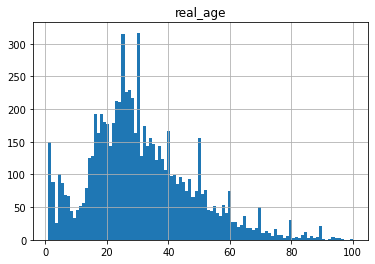

In [6]:
data.hist(bins=100)

В датасете, как было выявлено ранее, в основном молодежь и люди среднего возраста, однако есть большое количество детей. Пожилых людей и стариков очень мало по сравнению с прочими группами.

Распределение напоминает нормальное, но в нем присутствует два пика. Есть явно выраженные группы - детей и взрослых, каждая из которых содержит свой пик на гистограмме. Выбросы в данных отсутствуют, диапазон данных лежит в нормальных границах человеческого возраста.

Выведем на экран несколько случайных изображений. Сперва загрузим нужные изображения.

In [7]:
datagen = ImageDataGenerator(rescale=1/255)

In [8]:
datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=f'/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


In [9]:
features, target = next(datagen_flow)

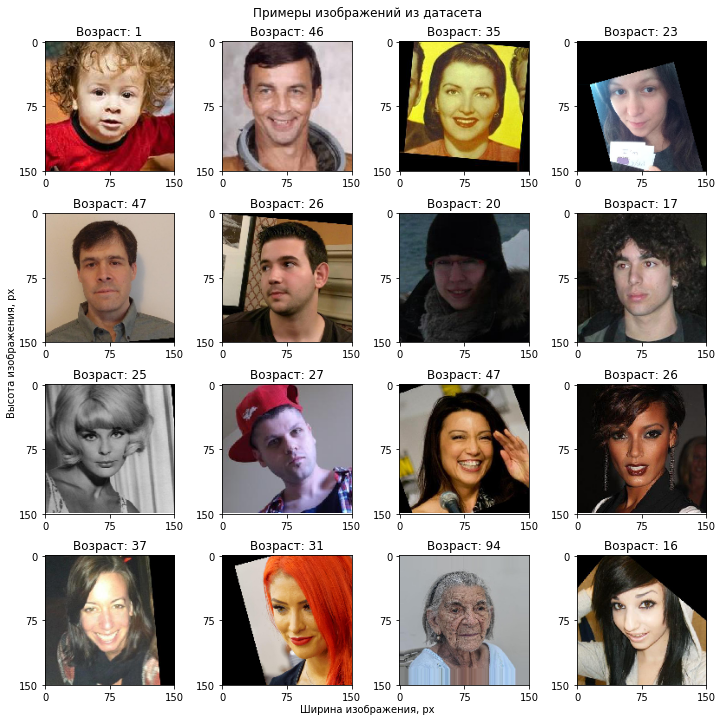

In [10]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Примеры изображений из датасета')
fig.text(.5,0,'Ширина изображения, px', ha='center')
fig.text(0,.5,'Высота изображения, px', va='center', rotation='vertical')
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([0,75,150])
    plt.yticks([0,75,150])
    plt.tight_layout()
    plt.title(f'Возраст: {target[i]}')

__Выводы:__

В датасете 7.5 тысяч изображений людей различного возраста, пола, национальности. Подавляющее большинство из них - дети, молодежь и люди среднего возраста. Средний возраст ~30 лет.

По выведенным на экран примерам фотографий можно предположить, что они предобработаны так, что бы лицо находилось в центре экрана и было вертикально ориентировано. За редким исключением это предположение подтверждается. В датасете не все изображения в цвете, некоторые из них представлены в черно-белом варианте. Все представленные изображения имеют размер 150х150 пикселя.

Соответственно при обучении модели необходимо будет добавить смещения и повороты изображения - это позволит достичь лучшего эффекта в реальных условиях, когда на фотографиях люди могут принимать нестандартные позы и находиться ближе к краю изображения.

## Обучение модели

#### Архитектура нейронной сети:

```python


from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import pandas as pd


def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255., horizontal_flip=True,
                                       rotation_range=20, width_shift_range=0.5,
                                       height_shift_range=0.5)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_datagen_flow


def load_test(path):

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(.8))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss=MeanSquaredError(),
                  metrics=[MeanAbsoluteError()])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

#### Результаты обучения:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 89 steps, validate for 30 steps

Epoch 1/30
WARNING:tensorflow:Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.

2022-07-21 10:24:03.311186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-07-21 10:24:04.229489: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

89/89 - 104s - loss: 336.8267 - mean_absolute_error: 13.6141 - val_loss: 608.4602 - val_mean_absolute_error: 19.6895
Epoch 2/30

89/89 - 97s - loss: 137.9211 - mean_absolute_error: 9.0100 - val_loss: 564.8892 - val_mean_absolute_error: 18.7681
Epoch 3/30

89/89 - 97s - loss: 117.8583 - mean_absolute_error: 8.3180 - val_loss: 489.9439 - val_mean_absolute_error: 17.0568 Epoch 4/30

89/89 - 96s - loss: 107.2604 - mean_absolute_error: 7.9320 - val_loss: 498.3319 - val_mean_absolute_error: 17.2834
Epoch 5/30

89/89 - 94s - loss: 96.9465 - mean_absolute_error: 7.5485 - val_loss: 421.4891 - val_mean_absolute_error: 15.4780
Epoch 6/30

89/89 - 96s - loss: 93.1387 - mean_absolute_error: 7.3500 - val_loss: 253.4355 - val_mean_absolute_error: 11.8091
Epoch 7/30

89/89 - 95s - loss: 83.4290 - mean_absolute_error: 7.0227 - val_loss: 168.1971 - val_mean_absolute_error: 9.5401
Epoch 8/30

89/89 - 96s - loss: 78.3858 - mean_absolute_error: 6.7702 - val_loss: 145.3061 - val_mean_absolute_error: 8.8698
Epoch 9/30

89/89 - 95s - loss: 76.1018 - mean_absolute_error: 6.6650 - val_loss: 127.6296 - val_mean_absolute_error: 8.4809
Epoch 10/30

89/89 - 95s - loss: 74.0280 - mean_absolute_error: 6.5590 - val_loss: 92.3614 - val_mean_absolute_error: 7.1053
Epoch 11/30

89/89 - 96s - loss: 71.0033 - mean_absolute_error: 6.3866 - val_loss: 74.1840 - val_mean_absolute_error: 6.3841
Epoch 12/30

89/89 - 96s - loss: 65.3371 - mean_absolute_error: 6.1603 - val_loss: 76.8198 - val_mean_absolute_error: 6.5399
Epoch 13/30

89/89 - 95s - loss: 59.6699 - mean_absolute_error: 5.9341 - val_loss: 107.6315 - val_mean_absolute_error: 7.7117
Epoch 14/30

89/89 - 96s - loss: 57.9835 - mean_absolute_error: 5.8256 - val_loss: 72.7726 - val_mean_absolute_error: 6.5844
Epoch 15/30

89/89 - 94s - loss: 57.5970 - mean_absolute_error: 5.7416 - val_loss: 167.4220 - val_mean_absolute_error: 9.9619
Epoch 16/30

89/89 - 95s - loss: 58.6522 - mean_absolute_error: 5.8183 - val_loss: 81.8183 - val_mean_absolute_error: 6.6327
Epoch 17/30

89/89 - 96s - loss: 54.2834 - mean_absolute_error: 5.5900 - val_loss: 136.2882 - val_mean_absolute_error: 8.8083
Epoch 18/30

89/89 - 96s - loss: 53.1696 - mean_absolute_error: 5.5314 - val_loss: 76.8433 - val_mean_absolute_error: 6.4396
Epoch 19/30

89/89 - 95s - loss: 53.0225 - mean_absolute_error: 5.4954 - val_loss: 104.9143 - val_mean_absolute_error: 7.2156
Epoch 20/30

89/89 - 95s - loss: 52.8641 - mean_absolute_error: 5.5321 - val_loss: 87.3524 - val_mean_absolute_error: 6.7246
Epoch 21/30

89/89 - 96s - loss: 50.2105 - mean_absolute_error: 5.3580 - val_loss: 71.6815 - val_mean_absolute_error: 6.3110
Epoch 22/30

89/89 - 95s - loss: 48.7134 - mean_absolute_error: 5.2410 - val_loss: 102.2704 - val_mean_absolute_error: 7.5097
Epoch 23/30

89/89 - 96s - loss: 46.8517 - mean_absolute_error: 5.1763 - val_loss: 74.7383 - val_mean_absolute_error: 6.3210
Epoch 24/30

89/89 - 96s - loss: 45.6248 - mean_absolute_error: 5.1060 - val_loss: 75.2203 - val_mean_absolute_error: 6.5853
Epoch 25/30

89/89 - 97s - loss: 44.5590 - mean_absolute_error: 5.0447 - val_loss: 69.2177 - val_mean_absolute_error: 6.1351
Epoch 26/30

89/89 - 96s - loss: 39.4900 - mean_absolute_error: 4.7600 - val_loss: 95.0830 - val_mean_absolute_error: 7.3013
Epoch 27/30

89/89 - 95s - loss: 41.4834 - mean_absolute_error: 4.9041 - val_loss: 89.9858 - val_mean_absolute_error: 6.8178
Epoch 28/30

89/89 - 95s - loss: 40.5150 - mean_absolute_error: 4.7724 - val_loss: 72.1782 - val_mean_absolute_error: 6.2900
Epoch 29/30

89/89 - 96s - loss: 41.4223 - mean_absolute_error: 4.8957 - val_loss: 75.3519 - val_mean_absolute_error: 6.3836
Epoch 30/30

89/89 - 95s - loss: 41.0500 - mean_absolute_error: 4.8382 - val_loss: 69.8390 - val_mean_absolute_error: 6.1961

30/30 - 10s - loss: 69.8390 - mean_absolute_error: 6.1961
Test MAE: 6.1961

```

Проанализируем модель и результаты ее обучения и тестирования.

## Анализ обученной модели

### Архитектура модели

В качестве основы была взята архитектура ResNet с глубиной в 50 слоев без финальных слоев. Архитектуру VGG, использовавшуюся исследователями, изучавшими этот датасет имплементировать не удалось - модель зависала на отметке в 13 MAE и далее не обучалась.

```python
...
from tensorflow.keras.applications.resnet import ResNet50
    ...
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    ...
```

Сверху готовой архитектуры было добавлено несколько слоев с уменьшающимся количеством нейронов с 500 на слой до 50 на слой. Последний слой был взят с одним нейроном, который осуществлял регрессионную функцию.

```python
    ...
    model.add(Dropout(.8))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss=MeanSquaredError(),
                  metrics=[MeanAbsoluteError()])
    ...
```

Для всех финальных слоев была взята функция активации ReLu, так как она позволяет смоделировать функцию только с положительными значениями, что справедливо для предсказания возраста человека на картинке - он не может быть отрицательным.

Для минимизации переобучения был добавлен дропаут слой с очень большим значением дропаута. Только 20% случайной информации от блока с архитектурой ResNet передается в финальные слои. Это позволило добавить большую долю неопределенности в обучении сети, так как у сети нет возможности сконцентрироваться на конкретных частях изображения и переобучиться, а требуется находить взаимосвязи даже на части данных.

Для примера аналогичная сеть была обучена с меньшими значениями дропаута (0.2, 0.5):

__Дропаут 0.2:__

```python
    ...
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(400, activation='relu'))
    
    ...
```

__Результат обучения:__

```

Epoch 26/30
89/89 - 94s - loss: 67.8047 - mean_absolute_error: 6.2359 - val_loss: 147.9527 - val_mean_absolute_error: 9.3093

Epoch 27/30
89/89 - 94s - loss: 63.0424 - mean_absolute_error: 5.9618 - val_loss: 99.8080 - val_mean_absolute_error: 7.3243

Epoch 28/30
89/89 - 94s - loss: 60.6413 - mean_absolute_error: 5.9251 - val_loss: 95.3554 - val_mean_absolute_error: 7.2883

Epoch 29/30
89/89 - 94s - loss: 59.1211 - mean_absolute_error: 5.8323 - val_loss: 122.9479 - val_mean_absolute_error: 7.8582

Epoch 30/30
89/89 - 94s - loss: 57.6694 - mean_absolute_error: 5.8153 - val_loss: 108.7514 - val_mean_absolute_error: 7.9965

30/30 - 10s - loss: 108.7514 - mean_absolute_error: 7.9965
Test MAE: 7.9965
```

__Дропаут 0.5:__

```python
    ...
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(.5))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(400, activation='relu'))
    
    ...
```

__Результат обучения:__

```
Epoch 26/30
89/89 - 95s - loss: 68.1524 - mean_absolute_error: 6.2746 - val_loss: 124.9771 - val_mean_absolute_error: 8.2456

Epoch 27/30
89/89 - 95s - loss: 66.0426 - mean_absolute_error: 6.1515 - val_loss: 144.1918 - val_mean_absolute_error: 9.1732

Epoch 28/30
89/89 - 95s - loss: 65.5144 - mean_absolute_error: 6.1610 - val_loss: 111.3053 - val_mean_absolute_error: 8.0071

Epoch 29/30
89/89 - 95s - loss: 61.3459 - mean_absolute_error: 5.9440 - val_loss: 108.2583 - val_mean_absolute_error: 7.7920

Epoch 30/30
89/89 - 94s - loss: 60.7691 - mean_absolute_error: 5.9112 - val_loss: 115.4822 - val_mean_absolute_error: 7.9189

30/30 - 10s - loss: 115.4822 - mean_absolute_error: 7.9189
Test MAE: 7.9189
```

Видно, что меньший уровень дропаута привел к снижению метрики на обучающей выборке, но не на валидационной, что привело ухудшению результата.

В качестве оптимизатора был выбран Adam как наиболее популярный и один из наиболее быстрых из всех имплементаций различных оптимизаций нейронных сетей для компьютерного зрения. Параметр скорости обучения в 0.0001 пусть и замедлил обучение, но позволил добиться оптимального уровня метрики.

Для обучения в качестве лосс функции была использована функция MSE. Она позволяет добиться результата быстрее, чем при использовании функции MAE. Однако стоит отметить, что несмотря на непрерывное снижение лосс функции на тренировочной выборке, значение метрики MAE снижалось не непрерывно, как на тренировочной, так и на валидационной выборке. Значение могло на некоторое время подниматься и снова опускаться. Таким образом несмотря на планомерное снижение в процессе спуска в пространстве MSE, в пространстве MAE модель спускалась неоптимально.

Модель обучалась 30 эпох. За меньшее количество эпох не удавалось добиться лучших значений метрики.

``` python
...
def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):
...
```

### Передаваемые данные

Данные, переданные в модель были предобработаны с помощью встроенных возможностей ImageDataGenerator. Картинки отражались по горизонтали, разворачивались до 20 градусов и смещались на значение до 50% от первонального изображения.

``` python
    ...
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255., horizontal_flip=True,
                                       rotation_range=20, width_shift_range=0.5,
                                       height_shift_range=0.5)
    ...
```

Размер батча был установлен на значении 64, при этом картинки использовались в разрешении выше исходного - 224 пикселей. Такой размер был принят в связи с тем, что исходная нейронная сеть была сконструирована и обучалась именно на таком разрешении изображений.

``` python
    ...
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='training',
        seed=42)
    ...
```

Тестовые данные не предобрабатывались, а загрузка их осуществлялась аналогично тренировочным.

``` python
    ...
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='validation',
        seed=42)

    ...
```

### Анализ результатов

До результатов авторов научной [статьи](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) о рассматриваемом датасете, модель оптимизировать не удалось, однако получилось достичь результата в 6.1961 MAE на тестовом датасете. Такой показатель максимально близок к результатам исследователей из статьи, которым удалось достичь показателя 5.4 MAE.

Лучший результат модели составлял 6.1351 MAE, что не слишком отличается от финального.

Ключевые факторы, которые позволили добиться указанного результата это скорость обучения, дропаут, выставленный выше рекомендованного значения в 0.5, аугментации, использование алгоритма оптимизации Adam, а в первую очередь готовая архитектура ResNet без последних слоев и несколько слоев нейронной сети с активатором ReLu с уменьшающимся количеством нейронов на слое.

Также важный параметр - количество эпох. При малом количестве в 5 и 10 эпох, сеть не успевала обучиться и качество достигало 10-11 MAE. При увеличении количества эпох, постепенно сеть приближалась к минимуму функции и скорость роста метрики падала, а достижение целевого показателя метрики в 8 MAE становилось стабильнее.

При снижении качества исходного изображения с 224 до 50 пикселей в ширину и высоту, модель также переставала обучаться и даже на дистанции в 60 эпох и размером батча в 128 оставалась на уровне метрики в 9-10 MAE.

При использовании картинок в оптимальном для нейросети качестве 224х224 на 45 и 60 эпохах, качество по достижении метрики в 6.2 MAE переставало снижаться, поэтому такое долгое обучение нейросети нецелесообразно.

Разработанная модель подходит для целей бизнеса, так как ее средняя ошибка составляет около 6 лет. Таким образом мы с достаточным уровнем точности можем выполнять первую функцию - предложение релевантных товаров для покупателей, что позволит получить дополнительные продажи. При такой ошибке самой проблемной для определения возраста группой станут подростки, ведь разница в 6 лет очень существенна для потребительских предпочтений ребенка. Но так как дети - не самая платежеспособная группа покупателей, потери от таких ошибок будут невелики. В наиболее крупной, платежеспособной и стабильной группе потребителей - покупателях среднего возраста и молодежи, точность определения возраста достаточна для предложения релевантных возрасту товаров.

Однако для второй задачи - определения возраста человека при продаже алкоголя, точности модели не хватит. Так как дети младшего возраста маловероятно будут покупать алкоголь, самая критичная группа - подростки от 15 до 18 лет. Для этой группы критично различие даже в полгода-год, поэтому для определения возраста клиента при продаже алкоголя, необходимо либо обучать отдельную нейронную сеть, либо улучшать текущую до очень высоких значений метрики в 0.5-1.5 года.